In [1]:
!pip install scikit-image
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Data location
data_dir = Path('./input')

## Training
train_dir = data_dir / 'train'

train_pneumonia = [['input/train/PNEUMONIA/' + i, 1]  for i in os.listdir(train_dir / 'PNEUMONIA') if i.endswith(".jpeg")]
train_healthy   = [['input/train/NORMAL/' + i, 0]     for i in os.listdir(train_dir / 'NORMAL') if i.endswith(".jpeg")]
train_pneumonia.extend(train_healthy)

df_train = pd.DataFrame(train_pneumonia, columns = ['img', 'label'], index=None)
# Shuffle the data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

## Validation
val_dir = data_dir / 'val'

val_pneumonia = [['input/val/PNEUMONIA/' + i, 1]  for i in os.listdir(val_dir / 'PNEUMONIA') if i.endswith(".jpeg")]
val_healthy   = [['input/val/NORMAL/' + i, 0]     for i in os.listdir(val_dir / 'NORMAL') if i.endswith(".jpeg")]
val_pneumonia.extend(val_healthy)

df_val = pd.DataFrame(val_pneumonia, columns = ['img', 'label'], index=None)
# Shuffle the data
df_val = df_val.sample(frac=1, random_state=42).reset_index(drop=True)

## Test
test_dir = data_dir / 'test'

test_pneumonia = [['input/test/PNEUMONIA/' + i, 1]  for i in os.listdir(test_dir / 'PNEUMONIA') if i.endswith(".jpeg")]
test_healthy   = [['input/test/NORMAL/' + i, 0]     for i in os.listdir(test_dir / 'NORMAL') if i.endswith(".jpeg")]
test_pneumonia.extend(test_healthy)

df_test = pd.DataFrame(test_pneumonia, columns = ['img', 'label'], index=None)
# Shuffle the data
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

train_counts = df_train['label'].value_counts()
val_counts = df_val['label'].value_counts()
test_counts = df_test['label'].value_counts()
print(train_counts, val_counts, test_counts)

df_train.head()

label
1    3875
0    1341
Name: count, dtype: int64 label
1    8
0    8
Name: count, dtype: int64 label
1    390
0    234
Name: count, dtype: int64


,img,label
0,input/train/PNEUMONIA/person299_bacteria_1418....,1
1,input/train/PNEUMONIA/person1415_virus_2425.jpeg,1
2,input/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg,0
3,input/train/NORMAL/NORMAL2-IM-0757-0001.jpeg,0
4,input/train/PNEUMONIA/person1924_bacteria_4833...,1


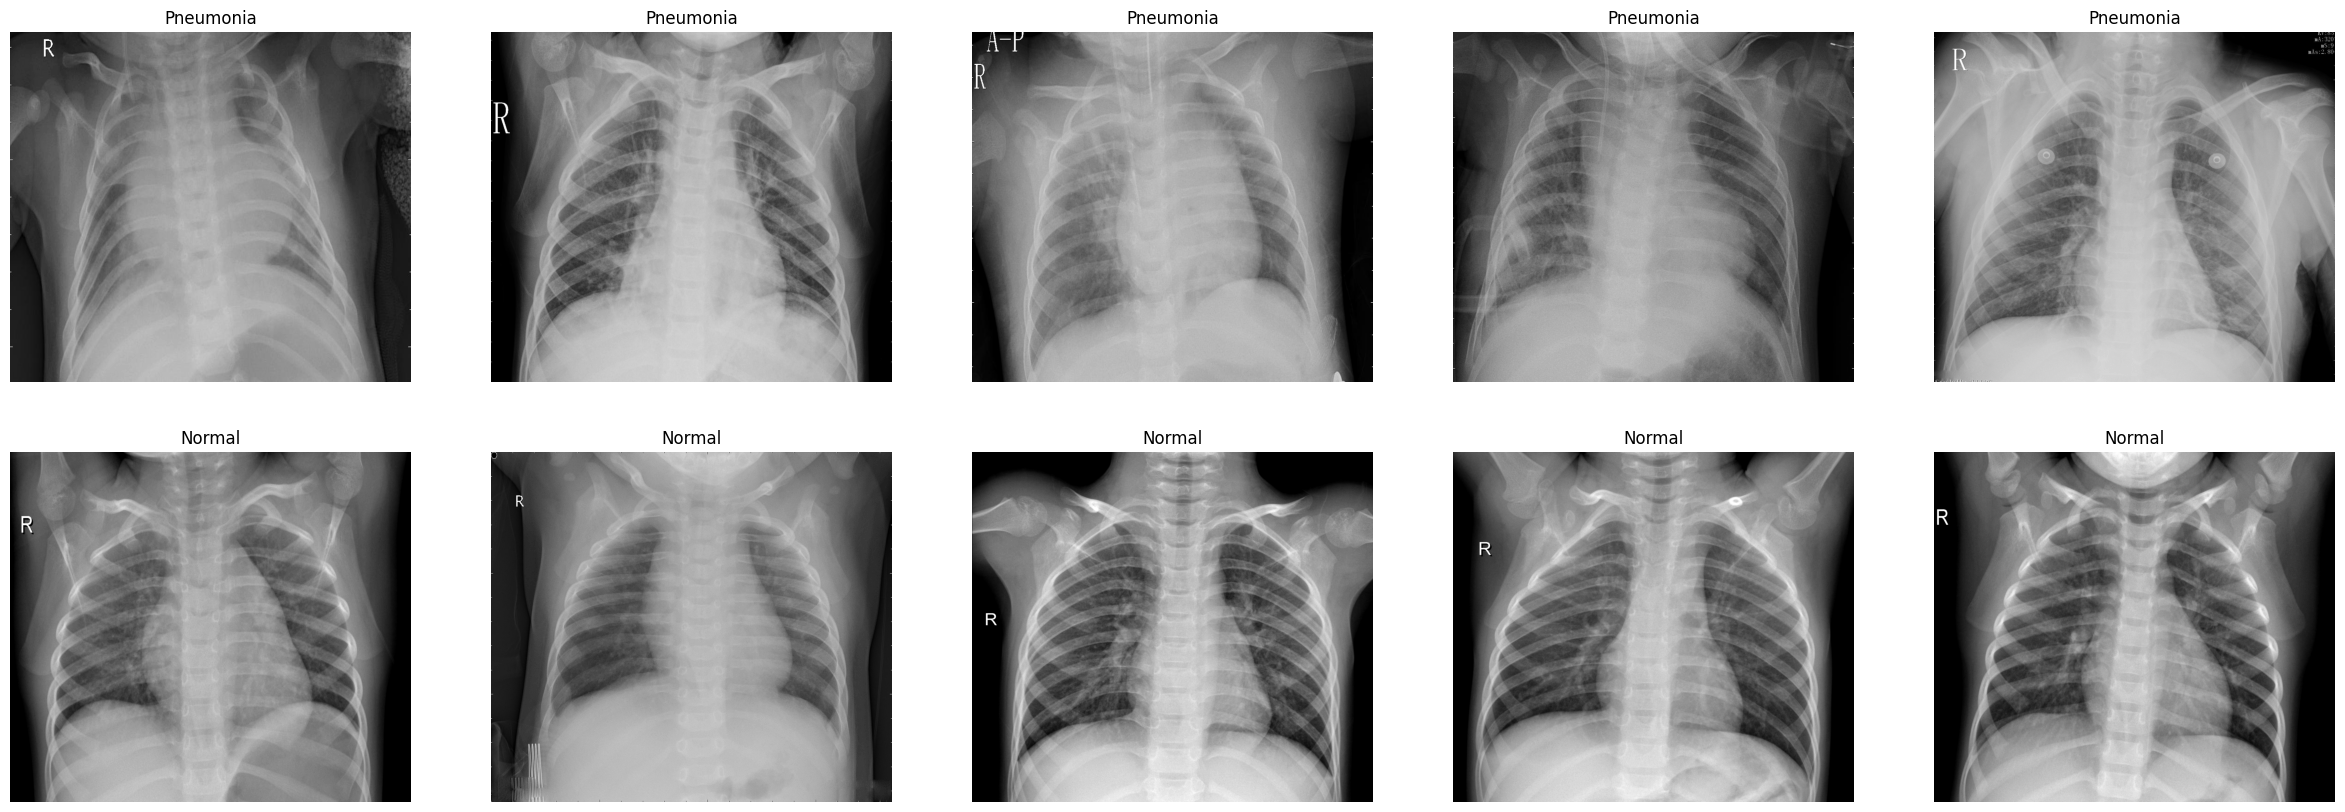

['input/train/PNEUMONIA/person299_bacteria_1418.jpeg',
 'input/train/PNEUMONIA/person1415_virus_2425.jpeg',
 'input/train/PNEUMONIA/person1924_bacteria_4833.jpeg',
 'input/train/PNEUMONIA/person1424_bacteria_3651.jpeg',
 'input/train/PNEUMONIA/person1597_bacteria_4194.jpeg',
 'input/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg',
 'input/train/NORMAL/NORMAL2-IM-0757-0001.jpeg',
 'input/train/NORMAL/NORMAL2-IM-0700-0001.jpeg',
 'input/train/NORMAL/NORMAL2-IM-0937-0001.jpeg',
 'input/train/NORMAL/IM-0650-0001-0002.jpeg']

In [3]:
# Get few samples for both the classes
pneumonia_samples = (df_train[df_train['label']==1]['img'].iloc[:5]).tolist()
normal_samples = (df_train[df_train['label']==0]['img'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

samples

In [4]:
class CNN(nn.Module):
    """ CNN class 
        Attributes:
        convolution (nn.Sequential): the cnn
        hidden_size (int): Size of the hidden layers
        pixel_size (int): Size of the pixel space
        output_size (int): Size of the output space
    """

    def __init__(self):
        super(CNN, self).__init__()

        self.convolution = nn.Sequential(
            # original input size: 200x200
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # size: 100 x 100 

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # size: 50 x 50
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.dense = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256 * (200//16) * (200//16), 256), # 64 x 50 x 50
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.convolution(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


In [5]:
EPOCHS = 10
BATCH_SIZE = 32
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # Assuming the image location is in the first column
        label = self.data.iloc[idx, 1]     # Assuming the label is in the second column
        
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        if self.transform:
            image = self.transform(image)
        
        return image, label
    

cnn = CNN()
# Define transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

# Create custom dataset
train = CustomDataset(dataframe=df_train, transform=transform)
val = CustomDataset(dataframe=df_val, transform=transform)
test = CustomDataset(dataframe=df_test, transform=transform)

# Create data loader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters())


In [6]:
## TRAINING LOOP
for epoch in range(EPOCHS):
    # TRAINING PHASE
    cnn.train() # set training mode
    train_loss = 0.0
    train_acc = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # forward pass
        outputs = cnn(inputs)
        # loss calculation
        loss = criterion(outputs, labels.unsqueeze(1).float())
        # backward pass
        loss.backward()
        # weight adjustment
        optimizer.step()
        
        # accuracy
        pred = outputs.round()
        correct = pred.eq(labels.view_as(pred)).sum().item()

        # metrics
        train_acc += correct / labels.numel()
        train_loss += loss.item()

    ## VALIDATION PHASE
    cnn.eval() # set evalidation mode
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad(): # to prevent the gradient computation, as we are not doing anything with it during validation
        for inputs, labels in val_loader:
             # forward pass
            outputs = cnn(inputs)
            # loss calculation
            loss = criterion(outputs, labels.unsqueeze(1).float())
            # no backward pass and optimizer step because no training

            # accuracy
            pred = outputs.round()
            correct = pred.eq(labels.view_as(pred)).sum().item()

            # metrics
            val_acc += correct / labels.numel()
            val_loss += loss.item()

    # epoch metrics
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_acc / len(val_loader)
    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = train_acc / len(train_loader)
    print(f"Epoch {epoch + 1} | Train: Loss: {epoch_train_loss:.4f},  Acc: {epoch_train_acc:.4f} | Val: Loss: {epoch_val_loss:.4f},  Acc: {epoch_val_acc:.4f}")
    
# TESTING
cnn.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        # forward pass
        outputs = cnn(inputs)
        # loss calculation
        loss = criterion(outputs, labels.unsqueeze(1).float())
        # no backward pass and optimizer step because no training

        # accuracy
        pred = outputs.round()
        correct = pred.eq(labels.view_as(pred)).sum().item()

        # metrics
        test_acc += correct / labels.numel()
        test_loss += loss.item()
avg_loss = test_loss / len(test_loader)
avg_acc = test_acc / len(test_loader)
print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {avg_acc:.4f}" )


Epoch 1 | Train: Loss: 0.3781,  Acc: 0.8301 | Val: Loss: 0.5255,  Acc: 0.8125
Epoch 2 | Train: Loss: 0.1437,  Acc: 0.9465 | Val: Loss: 0.1013,  Acc: 0.9375
